# The Damped Harmonic Oscillator in One Dimension

> This example is adapted from Ben Moseley's [blog post](https://web.archive.org/web/20240618153956/https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/).

The system is described by the following second-order differential equation:

$$
m \frac{d^2 u}{d t^2} + c \frac{d u}{d t} + ku = 0
$$

where:
- $m$ represents the mass of the oscillator
- $c$ is the damping coefficient
- $k$ is the spring constant
- $u$ denotes displacement
- $t$ represents time


The system starts from rest with unit displacement:

$$
u(0) = 1, \quad \frac{d u}{d t}(0) = 0
$$

We focus on the under-damped case, which occurs when:

$$
\delta < \omega_0
$$

The key parameters are:
- Damping ratio: $\delta = \frac{c}{2m}$
- Natural frequency: $\omega_0 = \sqrt{\frac{k}{m}}$

For under-damped motion, the solution takes the form:

$$
x(t) = e^{-\delta t}(2A \cos(\phi + \omega t))
$$

where:
- $\omega = \sqrt{\omega_0^2 - \delta^2}$ is the damped frequency
- $A$ is the amplitude coefficient
- $\phi$ represents the phase angle


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def oscillator(d, w0, x):
    """Analytical solution to the 1D underdamped harmonic oscillator problem."""
    assert d < w0
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d / w)
    A = 1 / (2 * np.cos(phi))
    cos = np.cos(phi + w * x)
    exp = np.exp(-d * x)
    y = exp * 2 * A * cos
    return y

def create_spring_oscillator_animation_inline():
    d = 2  # damping coefficient
    w0 = 20  # natural frequency
    
    # Animation variables
    totalTime = 1.0  # Time domain [0, 1]
    dt = 0.0075
    t_array = np.arange(0, totalTime, dt)
    y_array = oscillator(d, w0, t_array)

    # Scaling factors
    scale = 1.0
    centerY = 0.0

    # Compute y_min and y_max from the displacement data
    y_min = np.min(y_array * scale + centerY)
    y_max = np.max(y_array * scale + centerY)

    # Create figure and axes
    fig, (ax_trace, ax_spring) = plt.subplots(1, 2, figsize=(12, 4))
    plt.tight_layout(pad=3.0)

    # Plot the displacement curve on ax_trace
    ax_trace.plot(t_array, y_array * scale + centerY, color='gray')
    trace_point, = ax_trace.plot([], [], 'bo', markersize=8)
    ax_trace.set_xlim(0, totalTime)
    ax_trace.set_ylim(-1.1, 1.1)  
    ax_trace.set_xlabel('Time (s)')
    ax_trace.set_ylabel('Displacement')
    ax_trace.set_title('Displacement vs. Time')

    # Set up the mass-spring system on ax_spring
    ax_spring.set_xlim(-1, 1)
    ax_spring.set_ylim(-1.1, 1.1)  
    ax_spring.axis('off')
    ax_spring.set_title('Mass-Spring System')

    # Draw the fixed block at equilibrium position (y=0)
    ax_spring.plot([-0.2, 0.2], [1.0, 1.0], 'k-', linewidth=4)

    # Initialize the mass and spring
    mass, = ax_spring.plot([], [], 'bo', markersize=20)
    spring_line, = ax_spring.plot([], [], 'k-', linewidth=1.5)

    def get_spring(y_start, y_end, coils=10, points_per_coil=15):
        length = y_end - y_start
        t = np.linspace(0, 1, coils * points_per_coil)
        x = 0.06 * np.sin(2 * np.pi * coils * t)
        y = y_start + length * t
        return x, y

    def update(frame):
        t = t_array[frame % len(t_array)]
        y = oscillator(d, w0, t) * scale + centerY

        # Update trace point
        trace_point.set_data([t], [y])

        # Update mass position
        mass.set_data([0], [y])

        # Update spring
        x_spring, y_spring = get_spring(1.0, y)  # Starting from y=1.0 (fixed point)
        spring_line.set_data(x_spring, y_spring)

        return trace_point, mass, spring_line

    ani = FuncAnimation(fig, update, frames=len(t_array), interval=20, blit=True)

    plt.close(fig)
    return HTML(ani.to_jshtml())

# Call the function to display the animation
create_spring_oscillator_animation_inline()

100%|██████████| 1000/1000 [00:00<00:00, 1821.30it/s]



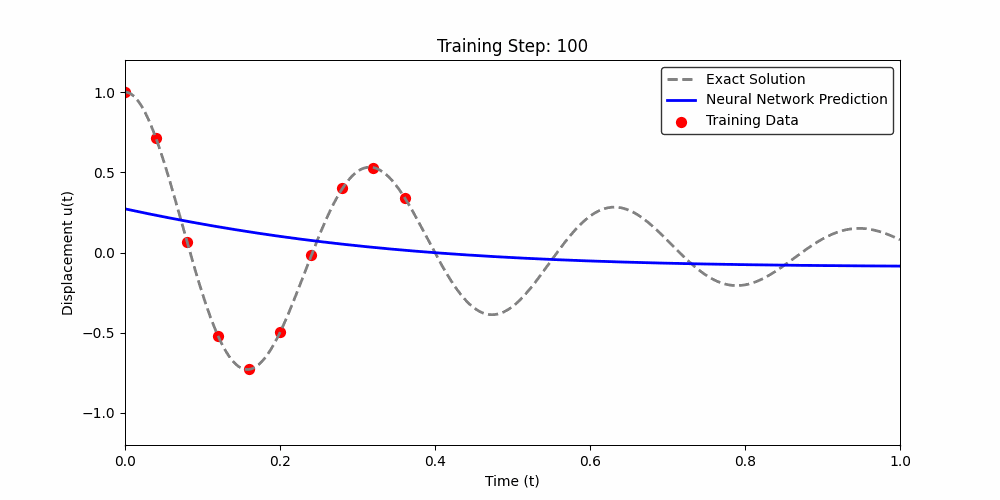

100%|██████████| 20000/20000 [00:14<00:00, 1368.19it/s]



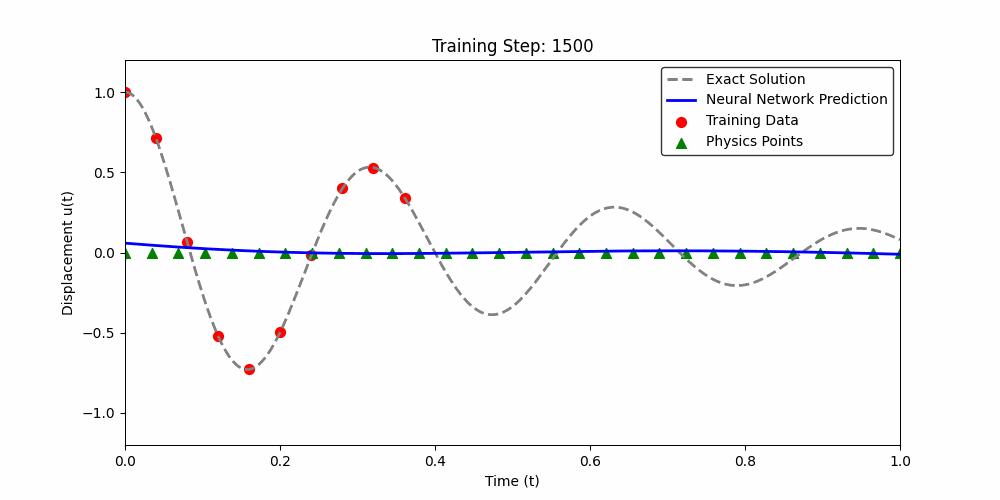

In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import base64
from IPython.display import HTML, display
import imageio
from tqdm import tqdm

class HarmonicOscillator:
    def __init__(self, damping_coefficient, natural_frequency):
        self.d = damping_coefficient
        self.w0 = natural_frequency
        assert self.d < self.w0, "Damping coefficient must be less than natural frequency for underdamped oscillator"
        self.w = np.sqrt(self.w0**2 - self.d**2)
        self.phi = np.arctan(-self.d / self.w)
        self.A = 1 / (2 * np.cos(self.phi))
        
    def analytical_solution(self, t):
        """Analytical solution to the 1D underdamped harmonic oscillator problem."""
        cos_part = np.cos(self.phi + self.w * t)
        exp_part = np.exp(-self.d * t)
        u = exp_part * 2 * self.A * cos_part
        return u
    
    def generate_data(self):
        """Generates training data for the oscillator."""
        t = np.linspace(0, 1, 500).reshape(-1, 1)
        u = self.analytical_solution(t).reshape(-1, 1)
        t_data = t[0:200:20]
        u_data = u[0:200:20]
        return t, u, t_data, u_data

class Visualizer:
    def __init__(self):
        # Remove seaborn style to have more control over the plot appearance
        plt.style.use('default')

    def plot_result(self, t, u_exact, t_data, u_data, u_pred, t_physics=None, iteration=None):
        """
        Plots the results with improved visualization.

        Args:
            t: time array for the full solution
            u_exact: exact displacement solution
            t_data: time array of training data points
            u_data: displacement data of training data points
            u_pred: predicted displacement from the neural network
            t_physics: optional physics points for PINN visualization
            iteration: optional iteration number for animation

        Returns:
            image: numpy array containing the plot image
        """
        fig, ax = plt.subplots(figsize=(10, 5))

        # Remove grid but keep the box
        ax.grid(False)
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)

        # Plot exact solution
        ax.plot(t, u_exact, color="gray", linewidth=2, linestyle='--', label="Exact Solution")

        # Plot neural network prediction
        ax.plot(t, u_pred, color="blue", linewidth=2, label="Neural Network Prediction")

        # Plot training data points
        ax.scatter(t_data, u_data, color="red", s=50, label="Training Data")

        # Plot physics points if provided (for PINN)
        if t_physics is not None:
            ax.scatter(t_physics, np.zeros_like(t_physics), color="green", s=50, label="Physics Points", marker="^")

        # Add iteration number if provided
        if iteration is not None:
            ax.set_title(f"Training Step: {iteration+1}")

        ax.legend(frameon=True, facecolor='white', edgecolor='black')
        ax.set_xlabel("Time (t)")
        ax.set_ylabel("Displacement u(t)")
        ax.set_xlim([t.min(), t.max()])
        ax.set_ylim([-1.2, 1.2])

        # Set background color to white
        ax.set_facecolor('white')
        fig.patch.set_facecolor('white')

        # Convert plot to image array
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        plt.close(fig)
        return image

    def create_animation(self, frames, filename='animation.gif'):
        """Creates and saves an animation from frames."""
        imageio.mimsave(filename, frames, fps=5)

    def display_animation(self, filename='animation.gif'):
        """Displays the animation as HTML."""
        with open(filename, 'rb') as f:
            data = f.read()
        data_url = "data:image/gif;base64," + base64.b64encode(data).decode()
        display(HTML('<img src="{}">'.format(data_url)))

class NeuralNetwork(nn.Module):
    def __init__(self, layer_sizes):
        super(NeuralNetwork, self).__init__()
        layers = []
        for in_size, out_size in zip(layer_sizes[:-1], layer_sizes[1:]):
            layers.append(nn.Linear(in_size, out_size))
            layers.append(nn.Tanh())
        layers.pop()  # Remove the last activation function
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

def pinn_loss(model, t_data, u_data, t_physics, mu, k):
    """Computes the loss for PINN, including data and physics losses."""
    # Data loss
    u_pred = model(t_data)
    loss_data = nn.MSELoss()(u_pred, u_data)

    # Physics loss
    t_physics = t_physics.clone().detach().requires_grad_(True)
    u_physics = model(t_physics)

    du_dt = torch.autograd.grad(u_physics, t_physics, grad_outputs=torch.ones_like(u_physics),
                                create_graph=True)[0]
    d2u_dt2 = torch.autograd.grad(du_dt, t_physics, grad_outputs=torch.ones_like(du_dt),
                                  create_graph=True)[0]

    physics = d2u_dt2 + mu * du_dt + k * u_physics
    loss_physics = 1e-4 * torch.mean(physics ** 2)

    return loss_data + loss_physics

def train_standard_nn(ho, visualizer):
    """Trains a standard neural network and creates an animation."""
    t, u_exact, t_data, u_data = ho.generate_data()

    # Initialize neural network model
    layer_sizes = [1, 32, 32, 32, 1]
    model = NeuralNetwork(layer_sizes)
    model.train()

    # Prepare data
    t_data_tensor = torch.tensor(t_data, dtype=torch.float32)
    u_data_tensor = torch.tensor(u_data, dtype=torch.float32)
    t_full_tensor = torch.tensor(t, dtype=torch.float32)

    # Define optimizer and loss function
    learning_rate = 1e-3
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Training loop
    num_steps = 1000
    frames = []

    for step in tqdm(range(num_steps)):
        model.train()
        optimizer.zero_grad()
        u_pred = model(t_data_tensor)
        loss = criterion(u_pred, u_data_tensor)
        loss.backward()
        optimizer.step()

        # Record frames for animation
        if (step + 1) % 100 == 0:
            model.eval()
            with torch.no_grad():
                u_pred_full = model(t_full_tensor).numpy()
            image = visualizer.plot_result(t, u_exact, t_data, u_data, u_pred_full, iteration=step)
            frames.append(image)

    # Create and display animation
    visualizer.create_animation(frames, filename='oscillator_nn.gif')
    visualizer.display_animation('oscillator_nn.gif')

def train_pinn(ho, visualizer):
    """Trains a physics-informed neural network and creates an animation."""
    t, u_exact, t_data, u_data = ho.generate_data()

    # Physics points for PINN
    t_physics = np.linspace(0, 1, 30).reshape(-1, 1)
    mu = 2 * ho.d
    k_param = ho.w0**2

    # Initialize neural network model
    layer_sizes = [1, 32, 32, 32, 1]
    model = NeuralNetwork(layer_sizes)
    model.train()

    # Prepare data
    t_data_tensor = torch.tensor(t_data, dtype=torch.float32)
    u_data_tensor = torch.tensor(u_data, dtype=torch.float32)
    t_full_tensor = torch.tensor(t, dtype=torch.float32)
    t_physics_tensor = torch.tensor(t_physics, dtype=torch.float32)
    mu_tensor = torch.tensor(mu, dtype=torch.float32)
    k_param_tensor = torch.tensor(k_param, dtype=torch.float32)

    # Define optimizer
    learning_rate = 1e-4
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    num_steps = 20000
    frames = []

    for step in tqdm(range(num_steps)):
        model.train()
        optimizer.zero_grad()

        loss = pinn_loss(model, t_data_tensor, u_data_tensor, t_physics_tensor, mu_tensor, k_param_tensor)
        loss.backward()
        optimizer.step()

        # Record frames for animation
        if (step + 1) % 1500 == 0:
            model.eval()
            with torch.no_grad():
                u_pred_full = model(t_full_tensor).numpy()
            image = visualizer.plot_result(t, u_exact, t_data, u_data, u_pred_full,
                                           t_physics=t_physics, iteration=step)
            frames.append(image)

    # Create and display animation
    visualizer.create_animation(frames, filename='oscillator_pinn.gif')
    visualizer.display_animation('oscillator_pinn.gif')

if __name__ == '__main__':
    # Initialize harmonic oscillator
    ho = HarmonicOscillator(damping_coefficient=2, natural_frequency=20)

    # Initialize visualizer
    visualizer = Visualizer()

    # Train standard neural network
    train_standard_nn(ho, visualizer)

    # Train PINN
    train_pinn(ho, visualizer)